# Suns-Voc(*T*) Analysis v1.8

#### Code by: Johannes Seif

***Note:*** The purpose of this jupyter notebook is to load and analyse data from the Suns-Voc(T) and Suns-PL(T) setup. The way it works is the following:

1) The user chooses a \*.smpl file that is stored in the same folder as all the data taken on this specific sample.

2) By executing the code below, the program will automatically load all the data files and do the calculations. ***Note*** that there is a convention for the file names. The standard way to measure should be without the white box, i.e. low illumination intensity. This is indicated by **'\_lo'** in the sample name. The high illumination intensity measurements, with the white box and the flash lowered to the box is to be indicated with a **'\_hi'** in the sample name. For the PL data files we don't make a distinction between **'lo'** and **'hi'**. The **'lo'** Suns-Voc measurements are used to get a value for the Voc@1sun which is used to shift the PL measurements to the right position. If no **'\_lo'** neither **'\_hi'** files are found in the sample folder the code will load any other Suns-Voc file. 

3) The program will output all the calculated data as \*.txt files in a folder "\_calcData". These files may then bus imported in any other software (e.g. Origin, Excel, etc.)

## Preamble

***Note:*** All the required packages are imported here.

In [1]:
# for calculations
import numpy as np
from scipy import stats
from SunsVoc import Suns_Voc_Measurement as sv
import SunsPL as pl
from glob import glob

# for jupyter
from PyQt5.QtWidgets import QFileDialog, QApplication
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox, HBox, IntProgress
from IPython.display import clear_output, display
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

#other
import matplotlib.pyplot as plt
from scipy.stats import linregress
# import littleBigHelpers as lBH
from littleBigHelpers import walklevel, getTemp

# for file handling
from ipyfilechooser import FileChooser # to choose the *.smpl file
import os
import sys
import platform # to determine the platforme Windows or MacOS
import time
import configparser # to read the *.smpl file
import shutil

# Choose the *.smpl file

***Note:*** Here the user can chose the \*.smpl (sample) file that contains the wafer thickness [cm], the base resistivity [Ohm.cm], the doping type [n- or p-type], the short circuit current density [A/cm2] and the calibration constant for the reference photodiode [V/suns]. All these parameters are essential for the calculation different parameters.

In [2]:
# Create and display a FileChooser widget
smpl = FileChooser(os.getcwd())
display(smpl)

FileChooser(path='C:\Users\z3525973\OneDrive - UNSW\Projects\SV Suns-Voc\02_Data\_SunsVocPL', filename='', sho…

# Set constants

In [3]:
# Number of points that are used to calculate the local ideality factor, i.e. the local slope of
# the Suns-Voc curve.
idealityPoints = 8

In the following the paths of the *.smpl file as well as of all the *.sun files (Suns-Voc data files) are collected. Furthermore, the parameters contained in the *.smpl file are stored. Note that parameters in the *.smpl file need to be in a specific order.

In [4]:
"""Get the sample folder path, i.e. the folder in which all the data is stored."""
"""Get the path to the *.smpl file that contains some information about the sample and measurement."""
sampleFolder = smpl.selected_path
smplPath = smpl.selected

# remove _calcData
dirpath = os.path.join(sampleFolder, "_calcData")
if os.path.exists(dirpath):
    shutil.rmtree(dirpath)

# remove _calcData-merged
dirpath = os.path.join(sampleFolder, "_calcData-merged")
if os.path.exists(dirpath):
    shutil.rmtree(dirpath)
                  
"""To determine which operating system is running and which path-separator to use."""
if platform.system() == 'Windows':
    
    slash = '\\'
    
elif platform.system() == 'Darwin':
    
    slash = '/'

"""Extract the parameters from the selected *.smpl file."""
with open(smplPath) as fp:
    
    config = configparser.ConfigParser(allow_no_value=True)
    config.readfp(fp)    
    waferThickness = float(config['Sample']['waferThickness'])
    baseResistivity = float(config['Sample']['baseResistivity'])
    jsc = config['Sample']['jsc'].split(',') # takes single values of jsc or a list separated by ','
    jsc = [float(i) for i in jsc] # jsc list with float values
    TCjsc = float(config['Sample']['TCjsc']) # temperature coefficient Jsc
    JscT = float(config['Sample']['JscT']) # measurement temperature at which the only Jsc value was measured
    JscTS = config['Sample']['JscTS'].split(',') # takes a list of T values separated by ','
    JscTS = [float(i) for i in JscTS] # T list with float values
    TS = config['Sample']['TS'].split(',') # takes single values of TS or a list separated by ','
    TS = [float(i) for i in TS] # TS list with float values
    baseType = config['Sample']['baseType']
    calConstantLO = float(config['Measurement']['calConstantLO'])

######################################################################################################
# SUNS-VOC DATA ANALYSIS #############################################################################
######################################################################################################

"""sunFiles is the array that contains all the names of the Suns-Voc files in the selected folder."""
"""These files will be sorted by low (lo) and high (hi) intensity measurements."""
sunFilesLO = []
sunFilesHI = []
sunFilesSTD = []
NoFilesFound_lo = 0
NoFilesFound_hi = 0
NoFilesFound_std = 0
SunsDataListLO = []
SunsDataListHI = []
SunsDataListSTD = []

numFileList = [0, 0, 0]
for root, dirs, files in walklevel(sampleFolder, level=0):
    for file in files:
        
        if file.find('_Voc') > -1 and file.find('.sun') > -1:
            if file.find('_lo') > -1:
                sunFilesLO.append(file)
                numFileList[0] += 1
            elif file.find('_hi') > -1:
                sunFilesHI.append(file)
                numFileList[1] += 1
            elif file.find('_lo') == -1 and file.find('_hi') == -1:
                sunFilesSTD.append(file)
                numFileList[2] += 1

if len(sunFilesLO) == 0:
    NoFilesFound_lo = 1

if len(sunFilesHI) == 0:
    NoFilesFound_hi = 1
    
if len(sunFilesSTD) == 0:
    NoFilesFound_std = 1

"""sunPaths is the array that contains all the paths to the Suns-Voc files."""
sunPathsLO = []
sunPathsHI = []
sunPathsSTD = []

if NoFilesFound_lo == 0:

    for i in sunFilesLO:
        sunPathsLO.append(os.path.join(sampleFolder, i))
    
if NoFilesFound_hi == 0:
    
    for i in sunFilesHI:
        sunPathsHI.append(os.path.join(sampleFolder, i))
        
if NoFilesFound_lo == 1 and NoFilesFound_hi == 1:
    
    for i in sunFilesSTD:
        sunPathsSTD.append(os.path.join(sampleFolder, i))

# check if the number jsc values given in the smpl file corresponds to the number of data files
# if there's only one value extrapolate the rest of the values

check = 0
checkAgain = 0
# get the number of files
numFileLists = 3 - NoFilesFound_lo - NoFilesFound_hi - NoFilesFound_std
numFiles = int((len(sunFilesLO) + len(sunFilesHI) + len(sunFilesSTD)) / numFileLists)

if NoFilesFound_lo == 0 or NoFilesFound_hi == 0 or NoFilesFound_std == 0:
    if not (len(sunFilesLO) == len(jsc)) or not (len(sunFilesHI) == len(jsc)) or not (len(sunFilesSTD) == len(jsc)):
       
        if len(jsc) == 1:
            if TCjsc == 0:
                checkAgain = 1
            else:
                check = 1
                njsc = []
                # calculate the Jsc values for all the temperatures at which Suns-Voc was measured
                for i in range(numFiles):
                    njsc.append(jsc[0] + (TS[i] - JscT) * TCjsc)
                
                # replace the old jsc by the new one that was calculated
                jsc = njsc
                
        elif len(jsc) > 1:
            check = 1
            slope, intercept, r_value, p_value, std_err = linregress(JscTS, jsc)
            TCjsc = slope
           
            # get the start value
            njsc = []
            jsc_start = jsc[0]
            # calculate the Jsc values for all the temperatures at which Suns-Voc was measured
            for i in range(numFiles):
                njsc.append(jsc_start + (TS[i] - JscTS[0]) * slope)
            
            # replace the old jsc by the new one that was calculated
            jsc = njsc

if check == 1:
    print("Please NOTE that the Jsc values were extrapolated using the following values.\n")
    print("\tJsc [A/cm2]: %s" % str('{:.3e}'.format(jsc[0])))
    print("\tJsc measured at T [°C]: %s" % str(JscT))
    print("\tTCjsc [A/cm2/°C]: %s\n" % str('{:.3e}'.format(TCjsc)))

print("The following Suns-Voc files have been found. LO: %s, HI: %s and STD: %s\n"
      % (str(numFileList[0]), str(numFileList[1]), str(numFileList[2])))

if checkAgain == 1:
    print("No TCjsc value was defined in the *.smpl file. Please correct that and start over.")
    
else:
    # Create the directory
    if not os.path.isdir(sampleFolder + slash + "_calcData"):
        os.mkdir(sampleFolder + slash + "_calcData")
    
    a = smpl.selected.split(slash)[len(smpl.selected.split(slash))-1]
    b = a[:a.find(".smpl")]
    fcellParameters = open(os.path.join(sampleFolder + slash + "_calcData", b + "Cell_Parameters.txt"), "w")
    fcellParameters.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\t {11}\n"
        .format(
            "sample",
            "T",
            "Voc",
            "Jsc",
            "Vmpp",
            "Jmpp",
            "pFF",
            "pEff",
            "suns@mpp",
            "m(Vmpp)",
            "m(Voc)",
            "delta Suns(LO to HI)",
            "cal const"
        )
    )
    fcellParameters.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\t {11}\n"
        .format(
            " ",
            "[°C]",
            "[V]",
            "[A/cm2]",
            "[V]",
            "[A/cm2]",
            "[%]",
            "[%]",
            "[suns]",
            " ",
            " ",
            "[V]",
            " "
        )
    )
    fcellParameters.write("\n")
    
    # If LO files have been found
    if NoFilesFound_lo == 0:

        """Calculate the Suns-Voc LO data"""
        progSuns = IntProgress(min=0, max=len(sunFilesLO))
        print("Calculating Suns-Voc LO data... please wait.")
        display(progSuns)

        # Collect Voc values. Used to shift the PL data.
        cVoc = np.array([])
        cVocOneSun = np.array([])
        cSuns = np.array([])

        j = -1
        for pathDataLO in sunPathsLO:

            j += 1 

            """Extract the parameters from the data file."""
            mTemp = getTemp(pathDataLO)

            """
            Create new Suns_Voc_Measurement objects, i.e. import the data, do the calculations and
            export the calcuated values.
            """
            SunsData = sv(
                sp = sampleFolder, # path to all the measurement files
                f = pathDataLO, # file path
                fn = sunFilesLO[j], # file name
                jsc = jsc[j], # short-circuit current density [A/cm2]
                wThick = waferThickness, # wafer thickness [cm]
                idealityPts=idealityPoints, # number of points to calculate the local ideality factor
                rBase = baseResistivity, # base resistivity [Ohm.cm]
                T = mTemp, # sample temperature [°C]
                VocLO = 0, # Voc values from the lo measurments
                VocOneSunLO = 0,
                SunsLO = 0,
                SunsDataLO = 0,
                dType = baseType, # n-type or p-type 
                refCal = calConstantLO, # calibration constant for the reference photodiode [V/suns]
                aMode = 'GEN'
            )

            fcellParameters.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\n"
                .format(
                    SunsData.sn,
                    np.round(SunsData.T),
                    np.round(SunsData.Voc,4),
                    np.round(SunsData.jsc,5),
                    np.round(SunsData.Vmpp,4),
                    np.round(SunsData.Jmpp,4),
                    np.round(SunsData.pFF / 0.01,1),
                    np.round(SunsData.pEff / 0.01,1),
                    np.round(SunsData.mppSuns,5),
                    np.round(SunsData.mppIdeality,3),
                    np.round(SunsData.mVoc,3)
                )
            )
            
            # cVoc is used to shift the HI data to the LO data. This is done by finding the
            # measured Voc value in the HI dataset that is closest to SunsData.raw['volt'][9]
            # value in the LO dataset and then minimizing the difference in suns by changing
            # the refCal value iteratively until the difference is smaller than a given threshold.
            cVoc = np.append(cVoc, SunsData.raw['volt'][0])
            cVocOneSun = np.append(cVocOneSun, SunsData.Voc)
            cSuns = np.append(cSuns, SunsData.raw['suns'][0])
            SunsDataListLO.append(SunsData)
            SunsData.Summarize_Voc(0)
            print("Data imported. " + SunsData.fn)
            progSuns.value += 1

            # get the doping for the PL measurements
            Na = SunsData.Na
            Nd = SunsData.Nd

    if NoFilesFound_hi == 0:

        """Calculate the Suns-Voc HI data"""
        progSunsHI = IntProgress(min=0, max=len(sunFilesHI))
        print("Calculating Suns-Voc HI data... please wait.")
        display(progSunsHI)

        crefCal = np.array([])
        j = -1
        for pathDataHI in sunPathsHI:

            j += 1 

            """Extract the parameters from the data file."""
            mTemp = getTemp(pathDataHI)

            """
            Create new Suns_Voc_Measurement objects, i.e. import the data, do the calculations and
            export the calcuated values.
            """
            SunsData = sv(
                sp = sampleFolder, # path to all the measurement files
                f = pathDataHI, # file path
                fn = sunFilesHI[j], # file name
                jsc = jsc[j], # short-circuit current density [A/cm2]
                wThick = waferThickness, # wafer thickness [cm]
                rBase = baseResistivity, # base resistivity [Ohm.cm]
                idealityPts=idealityPoints, # number of points to calculate the local ideality factor
                T = mTemp, # sample temperature [°C]
                VocLO = cVoc[j], # Voc values of the LO measurments to which the closest value in the HI data will be found
                VocOneSunLO = cVocOneSun[j],
                SunsLO = cSuns[j], # Suns value to which the HI measurement will be matched
                SunsDataLO = SunsDataListLO[j], # the entire raw and calculated data of a LO measurement at the same temperature
                dType = baseType, # n-type or p-type 
                refCal = calConstantLO, # calibration constant for the reference photodiode [V/suns]
                aMode = 'GEN'
            )

            fcellParameters.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\t {11}\t {12}\n"
                .format(
                    SunsData.sn,
                    np.round(SunsData.T),
                    np.round(SunsData.Voc,4),
                    np.round(SunsData.jsc,5),
                    np.round(SunsData.Vmpp,4),
                    np.round(SunsData.Jmpp,4),
                    np.round(SunsData.pFF / 0.01,1),
                    np.round(SunsData.pEff / 0.01,1),
                    np.round(SunsData.mppSuns,5),
                    np.round(SunsData.mppIdeality,3),
                    np.round(SunsData.mVoc,3),
                    np.round(SunsData.dsuns, 4),
                    np.round(SunsData.refCal, 4)
                )
            )

            crefCal = np.append(crefCal, SunsData.refCal)
            SunsDataListHI.append(SunsData)
            SunsData.Summarize_Voc(0)
            print("Data imported. " + SunsData.fn)
            progSunsHI.value += 1

            # get the doping for the PL measurements
            Na = SunsData.Na
            Nd = SunsData.Nd

    if NoFilesFound_std == 0:

        """Calculate the Suns-Voc STD data"""
        progSunsSTD = IntProgress(min=0, max=len(sunFilesSTD))
        print("Calculating Suns-Voc STD data... please wait.")
        display(progSunsSTD)
        
        # Collect Voc values. Used to shift the PL data.
#         cVoc = np.array([])

        j = -1
        for pathDataSTD in sunPathsSTD:

            j += 1 

            """Extract the parameters from the data file."""
            mTemp = getTemp(pathDataSTD)

            """
            Create new Suns_Voc_Measurement objects, i.e. import the data, do the calculations and
            export the calcuated values.
            """
            SunsData = sv(
                sp = sampleFolder, # path to all the measurement files
                f = pathDataSTD, # file path
                fn = sunFilesSTD[j], # file name
                jsc = jsc[j], # short-circuit current density [A/cm2]
                wThick = waferThickness, # wafer thickness [cm]
                rBase = baseResistivity, # base resistivity [Ohm.cm]
                idealityPts=idealityPoints, # number of points to calculate the local ideality factor
                T = mTemp, # sample temperature [°C]
                VocLO = 0, # Voc values from the lo measurments
                VocOneSunLO = 0,
                SunsLO = 0,
                SunsDataLO = 0,
                dType = baseType, # n-type or p-type 
                refCal = calConstantLO, # calibration constant for the reference photodiode [V/suns]
                aMode = 'GEN'
            )

            fcellParameters.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\n"
                .format(
                    SunsData.sn,
                    np.round(SunsData.T),
                    np.round(SunsData.Voc,4),
                    np.round(SunsData.jsc,5),
                    np.round(SunsData.Vmpp,4),
                    np.round(SunsData.Jmpp,4),
                    np.round(SunsData.pFF / 0.01,1),
                    np.round(SunsData.pEff / 0.01,1),
                    np.round(SunsData.mppSuns,5),
                    np.round(SunsData.mppIdeality,3),
                    np.round(SunsData.mVoc,3)
                )
            )
            
#             cVoc = np.append(cVoc, SunsData.Voc)
            SunsDataListSTD.append(SunsData)
            SunsData.Summarize_Voc(0)
            progSunsSTD.value += 1

            # get the doping for the PL measurements
            Na = SunsData.Na
            Nd = SunsData.Nd

    fcellParameters.close()
    
    ######################################################################################################
    # MERGE LO AND HI DATA  ##############################################################################
    ######################################################################################################
    if not len(SunsDataListLO) == 0 and not len(SunsDataListHI) == 0:

        if not len(SunsDataListLO) == len(SunsDataListHI):
            print("The number of LO and HI is not the same. Check your data.")

        else:
            
            progSunsMerge = IntProgress(min=0, max=len(sunFilesLO))
            print("Merging the Suns-Voc LO and HI data... please wait.")
            display(progSunsMerge)
        
            for j in range(len(SunsDataListLO)):

                MergedData = SunsDataListLO[j].MergeData(SunsDataListLO, SunsDataListHI, j)
                
                if not os.path.isdir(SunsDataListLO[j].sp + slash + "_calcData-merged"):
                    os.mkdir(SunsDataListLO[j].sp + slash + "_calcData-merged")
                
                if not os.path.isdir(SunsDataListLO[j].sp + slash + "_calcData-merged" + slash + "SV"):
                    os.mkdir(SunsDataListLO[j].sp + slash + "_calcData-merged" + slash + "SV")

                f2 = open(os.path.join(SunsDataListLO[j].sp +
                                       slash + 
                                       "_calcData-merged" + slash + "SV",
                                       SunsDataListLO[j].sn[:SunsDataListLO[j].sn.find("_lo")] + 
                                       "_T-" + 
                                       str(np.round(SunsDataListLO[j].T)) +
                                       "_SV.txt"), "w")
                
#                 "_LO-T-" + 
#                 str(np.round(SunsDataListLO[j].T)) +
#                 "_HI-T-" + 
#                 str(np.round(SunsDataListHI[j].T)) +
                
                check = 0

                for i in range(len(MergedData[0])):

                    if check == 0:
                        f2.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\t {11}"
                            .format(
                                "time",
                                "ref V (raw)",
                                "cell V (raw)",
                                "dVdt",
                                "Dn",
                                "net suns",
                                "eff. suns",
                                "tau_eff",
                                "J_eq",
                                "p density",
                                "ideality",
                                "cell V/Voc(1 sun)"
                            )
                        )

                        f2.write("\n")
                        
                        f2.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\t {11}"
                            .format(
                                "[s]",
                                "[V]",
                                "[V]",
                                "[V/s]",
                                "[cm-3]",
                                "[suns]",
                                "[suns]",
                                "[s]",
                                "[A/cm2]",
                                "[W/cm2]",
                                "[]",
                                "[]"
                            )
                        )
                        
                        f2.write("\n")
                        
                        f2.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\t {11}"
                            .format(
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C"
                            )
                        )

                        f2.write("\n")

                        check += 1
                        
                    else:

                        f2.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}\t {9}\t {10}\t {11}"
                            .format(
                                MergedData[0][i],
                                MergedData[1][i],
                                MergedData[2][i],
                                MergedData[3][i],
                                MergedData[4][i],
                                MergedData[5][i],
                                MergedData[6][i],
                                MergedData[7][i],
                                MergedData[8][i],
                                MergedData[9][i],
                                MergedData[10][i],
                                MergedData[11][i]
                            )
                        )

                        f2.write("\n")
                    
                progSunsMerge.value += 1

                f2.close()

    ######################################################################################################
    # PL DATA ANALYSIS ###################################################################################
    ######################################################################################################
    
    """plFiles is the array that contains all the names of the PL data files in the selected folder."""
    plFilesLO = []
    plFilesHI = []
    plFilesSTD = []
    NoFilesFound_lo_PL = 0
    NoFilesFound_hi_PL = 0
    NoFilesFound_std_PL = 0
    numFileList = [0, 0, 0]
    PLDataListLO = []
    PLDataListHI = []
    PLDataListSTD = []
    AiValsLO = []
    highestVocPLLO = []
    
    for root, dirs, files in walklevel(sampleFolder, level=0):
        for file in files:
            if file.find('_PL') > -1:
                if file.find('_lo') > -1:
                    plFilesLO.append(file)
                    numFileList[0] += 1
                elif file.find('_hi') > -1:
                    plFilesHI.append(file)
                    numFileList[1] += 1
                elif file.find('_lo') == -1 and file.find('_hi') == -1:
                    plFilesSTD.append(file)
                    numFileList[2] += 1
    
    if len(plFilesLO) == 0:
        NoFilesFound_lo_PL = 1

    if len(plFilesHI) == 0:
        NoFilesFound_hi_PL = 1

    if len(plFilesSTD) == 0:
        NoFilesFound_std_PL = 1
        
    print("The following Suns-PL files have been found. LO: %s, HI: %s and STD: %s\n"
          % (str(int(numFileList[0])), str(int(numFileList[1])), str(int(numFileList[2]))))
    
    if NoFilesFound_lo_PL == 0:

        """plPaths_LO is the array that contains all the paths to the PL data files."""
        plPaths_LO = []
        for i in plFilesLO:
            plPaths_LO.append(os.path.join(sampleFolder, i))

        """Calculate the Suns-PL data"""
        progPL = IntProgress(min=0, max=len(plFilesLO))
        print("Calculating Suns-PL LO data... please wait.")
        display(progPL)
        
        # Collect Voc values of the PL LO data. Used to shift the PL HI data.
        cVocPL = np.array([])
        
        j = -1
        for pathData in plPaths_LO:

            j += 1
            """Extract the parameters from the data file."""
            mTemp = getTemp(pathData)

            """
            Create new PL_Measurement objects, i.e. import the data, do the calculations and
            export the calcuated values.
            """
            PLData = pl.Voltage_Measurement(
                sp = sampleFolder, # path to all the measurement files
                f = pathData, # file path
                fn = plFilesLO[j], # file name
                W = waferThickness,
                rBase = baseResistivity,
                dType = baseType,
                jsc = jsc[j],
                refCal = calConstantLO,
                bkgnd_corr=0.9,
                VocSunsLo = cVocOneSun[j], # this is used to shift the PL data to the Suns-Voc data
                T = mTemp, # temperature in °C
                aMode = 'GEN',
                Ai_overwrite=0,
                highestVocPLLO=0
            )
            
            cVocPL = np.append(cVocPL, PLData.iVoc_1sun_corr)
            AiValsLO.append(PLData.Ai)
            highestVocPLLO.append(PLData.iVoc_corr[0])
            PLDataListLO.append(PLData)
            PLData.Summarize_PL()
            print("Data imported. " + PLData.fn)
            progPL.value += 1
            
    if NoFilesFound_hi_PL == 0:
        
        """plPaths_HI is the array that contains all the paths to the PL data files."""
        plPaths_HI = []
        for i in plFilesHI:
            plPaths_HI.append(os.path.join(sampleFolder, i))

        """Calculate the Suns-PL data"""
        progPL = IntProgress(min=0, max=len(plFilesHI))
        print("Calculating Suns-PL HI data... please wait.")
        display(progPL)
        
        j = -1
        for pathData in plPaths_HI:

            j += 1
            """Extract the parameters from the data file."""
            mTemp = getTemp(pathData)

            """
            Create new PL_Measurement objects, i.e. import the data, do the calculations and
            export the calcuated values.
            """
            PLData = pl.Voltage_Measurement(
                sp = sampleFolder, # path to all the measurement files
                f = pathData, # file path
                fn = plFilesHI[j], # file name
                W = waferThickness,
                rBase = baseResistivity,
                dType = baseType,
                jsc = jsc[j],
                refCal = crefCal[j], # this will ensure that the same refCal is used fro the HI Voc and PL data.
                bkgnd_corr=0.9,
                VocSunsLo = cVocPL[j], # this is used to shift the HI PL data to the LO PL data
                T = mTemp, # temperature in °C
                aMode = 'GEN',
                Ai_overwrite=AiValsLO[j],
                highestVocPLLO=highestVocPLLO[j]
            )
            
            PLDataListHI.append(PLData)
            PLData.Summarize_PL()
            print("Data imported. " + PLData.fn)
            progPL.value += 1
        
    if NoFilesFound_std_PL == 0:
        
        """plPaths_STD is the array that contains all the paths to the PL data files."""
        plPaths_STD = []
        for i in plFilesSTD:
            plPaths_STD.append(os.path.join(sampleFolder, i))

        """Calculate the Suns-PL data"""
        progPL = IntProgress(min=0, max=len(plFilesSTD))
        print("Calculating Suns-PL HI data... please wait.")
        display(progPL)
        
        j = -1
        for pathData in plPaths_STD:

            j += 1
            """Extract the parameters from the data file."""
            mTemp = getTemp(pathData)

            """
            Create new PL_Measurement objects, i.e. import the data, do the calculations and
            export the calcuated values.
            """
            PLData = pl.Voltage_Measurement(
                sp = sampleFolder, # path to all the measurement files
                f = pathData, # file path
                fn = plFilesSTD[j], # file name
                W = waferThickness,
                rBase = baseResistivity,
                dType = baseType,
                jsc = jsc[j],
                refCal = calConstantLO,
                bkgnd_corr=0.9,
                VocSunsLo = cVoc[j], # this is used to shift the STD PL data to the STD Voc data
                T = mTemp, # temperature in °C
                aMode = 'GEN',
                Ai_overwrite=0,
                highestVocPLLO=0
            )
            
            PLDataListSTD.append(PLData)
            PLData.Summarize_PL()
            progPL.value += 1
        
    else:
        
        print("No PL files have been found.")
        
    ######################################################################################################
    # MERGE LO AND HI DATA  ##############################################################################
    ######################################################################################################
    if not len(PLDataListLO) == 0 and not len(PLDataListHI) == 0:

        if not len(PLDataListLO) == len(PLDataListHI):
            print("The number of LO and HI is not the same. Check your data.")

        else:
            
            progSunsPLMerge = IntProgress(min=0, max=len(sunFilesLO))
            print("Merging the Suns-PL LO and HI data... please wait.")
            display(progSunsPLMerge)
        
            for j in range(len(PLDataListLO)):

                MergedData = PLDataListLO[j].MergeData(PLDataListLO, PLDataListHI, j)
                
                if not os.path.isdir(PLDataListLO[j].sp + slash + "_calcData-merged"):
                    os.mkdir(PLDataListLO[j].sp + slash + "_calcData-merged")
                    
                if not os.path.isdir(PLDataListLO[j].sp + slash + "_calcData-merged" + slash + "PL"):
                    os.mkdir(PLDataListLO[j].sp + slash + "_calcData-merged" + slash + "PL")

                f2 = open(os.path.join(PLDataListLO[j].sp +
                                       slash + 
                                       "_calcData-merged" + slash + "PL", 
                                       PLDataListLO[j].sn[:PLDataListLO[j].sn.find("_lo")] + 
                                       "_T-" + 
                                       str(np.round(PLDataListLO[j].T)) +
                                       "_PL.txt"), "w")
                
                check = 0

                for i in range(len(MergedData[0])):

                    if check == 0:
                        f2.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}"
                            .format(
                                "time",
                                "ref V (raw)",
                                "eff. suns",
                                "PL V (raw)",
                                "Dn",
                                "iVoc",
                                "iVoc_corr",
                                "dndt",
                                "ideality"
                            )
                        )

                        f2.write("\n")
                        
                        f2.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}"
                            .format(
                                "[s]",
                                "[V]",
                                "[suns]",
                                "[V]",
                                "[cm-3]",
                                "[V]",
                                "[V]",
                                "[cm-3/s]",
                                "[]"
                            )
                        )
                        
                        f2.write("\n")
                        
                        f2.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}"
                            .format(
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C",
                                str(np.round(SunsDataListLO[j].T)) + "°C"
                            )
                        )

                        f2.write("\n")

                        check += 1
                        
                    else:

                        f2.write("{0}\t {1}\t {2}\t {3}\t {4}\t {5}\t {6}\t {7}\t {8}"
                            .format(
                                MergedData[0][i],
                                MergedData[1][i],
                                MergedData[2][i],
                                MergedData[3][i],
                                MergedData[4][i],
                                MergedData[5][i],
                                MergedData[6][i],
                                MergedData[7][i],
                                MergedData[8][i]
                            )
                        )

                        f2.write("\n")
                    
                progSunsPLMerge.value += 1

                f2.close()
     
    print("All calculations DONE!")

Please NOTE that the Jsc values were extrapolated using the following values.

	Jsc [A/cm2]: 3.976e-02
	Jsc measured at T [°C]: 25.0
	TCjsc [A/cm2/°C]: 3.000e-05

The following Suns-Voc files have been found. LO: 22, HI: 22 and STD: 0

Calculating Suns-Voc LO data... please wait.


IntProgress(value=0, max=22)

Data imported. [2020_03_06T13_37_11]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[140.00].sun
Data imported. [2020_03_06T13_38_03]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[135.00].sun
Data imported. [2020_03_06T13_38_49]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[130.00].sun
Data imported. [2020_03_06T13_39_33]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[125.00].sun
Data imported. [2020_03_06T13_40_17]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[120.00].sun
Data imported. [2020_03_06T13_41_03]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[115.00].sun
Data imported. [2020_03_06T13_41_51]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[110.00].sun
Data imported. [2020_03_06T13_42_42]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[105.00].sun
Data imported. [2020_03_06T13_43_37]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[100.00].sun
Data imported. [2020_03_06T13_44_35]_[Al-BSF-multi-(full)-(with-filter)_lo]_Voc_[95.00].sun
Data imported. [2020_03_06T13_45_40]_[Al-BSF-multi-(full)-(with-filter)

IntProgress(value=0, max=22)

Data imported. [2020_03_06T14_45_02]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[140.00].sun
Data imported. [2020_03_06T14_46_05]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[135.00].sun
Data imported. [2020_03_06T14_46_53]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[130.00].sun
Data imported. [2020_03_06T14_47_39]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[125.00].sun
Data imported. [2020_03_06T14_48_25]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[120.00].sun
Data imported. [2020_03_06T14_49_12]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[115.00].sun
Data imported. [2020_03_06T14_50_00]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[110.00].sun
Data imported. [2020_03_06T14_50_51]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[105.00].sun
Data imported. [2020_03_06T14_51_46]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[100.00].sun
Data imported. [2020_03_06T14_52_45]_[Al-BSF-multi-(full)-(with-filter)_hi]_Voc_[95.00].sun
Data imported. [2020_03_06T14_53_50]_[Al-BSF-multi-(full)-(with-filter)

IntProgress(value=0, max=22)

The following Suns-PL files have been found. LO: 22, HI: 22 and STD: 0

Calculating Suns-PL LO data... please wait.


IntProgress(value=0, max=22)

Data imported. [2020_03_06T13_37_11]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[140.00].sun
Data imported. [2020_03_06T13_38_03]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[135.00].sun
Data imported. [2020_03_06T13_38_49]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[130.00].sun
Data imported. [2020_03_06T13_39_33]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[125.00].sun
Data imported. [2020_03_06T13_40_17]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[120.00].sun
Data imported. [2020_03_06T13_41_03]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[115.00].sun
Data imported. [2020_03_06T13_41_51]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[110.00].sun
Data imported. [2020_03_06T13_42_42]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[105.00].sun
Data imported. [2020_03_06T13_43_37]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[100.00].sun
Data imported. [2020_03_06T13_44_35]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[95.00].sun
Data imported. [2020_03_06T13_45_40]_[Al-BSF-multi-(full)-(with-filter)_lo]_PL_[9

IntProgress(value=0, max=22)

Data imported. [2020_03_06T14_45_02]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[140.00].sun
Data imported. [2020_03_06T14_46_05]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[135.00].sun
Data imported. [2020_03_06T14_46_53]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[130.00].sun
Data imported. [2020_03_06T14_47_39]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[125.00].sun
Data imported. [2020_03_06T14_48_25]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[120.00].sun
Data imported. [2020_03_06T14_49_12]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[115.00].sun
Data imported. [2020_03_06T14_50_00]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[110.00].sun
Data imported. [2020_03_06T14_50_51]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[105.00].sun
Data imported. [2020_03_06T14_51_46]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[100.00].sun
Data imported. [2020_03_06T14_52_45]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[95.00].sun
Data imported. [2020_03_06T14_53_50]_[Al-BSF-multi-(full)-(with-filter)_hi]_PL_[9

IntProgress(value=0, max=22)

All calculations DONE!


In [ ]:
SunsData.fn

# Sanity checks

Below you can plot data by changing the "a" value from 0 = first file, to 1 = next file, to 2...

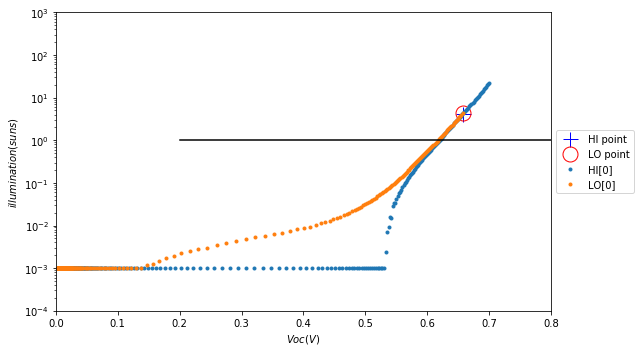

In [15]:
"""Sanity check for the matching of LO and HI data."""
a = 21
ptHI = SunsDataListHI[a].indClosestVoc

fig, ax  = plt.subplots(figsize=(9,5), tight_layout=True)
ax.plot(SunsDataListLO[a].raw['volt'][0], SunsDataListHI[a].highSunsHI, 'b+', label = 'HI point', markersize=15)
ax.plot(SunsDataListLO[a].raw['volt'][0], SunsDataListLO[a].effSuns[0], 'ro', fillstyle="none", label = 'LO point', markersize=15)
ax.plot(SunsDataListHI[a].raw['volt'], SunsDataListHI[a].effSuns,'.', label = 'HI[0]')
ax.plot(SunsDataListLO[a].raw['volt'], SunsDataListLO[a].effSuns,'.', label = 'LO[0]')
ax.plot([0.2,0.9],[1,1],'k-')
# ax.plot(SunsDataListSTD[a].raw['volt'], SunsDataListSTD[a].effSuns,'.', label = 'STD')

# define the legend and set it to visible
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_visible(True)

# set the plot to log-log and set the limits and axis labels
plt.yscale("log")
plt.xlim(0.0,0.8)
plt.ylim(0.0001,1e3)
plt.xlabel(r'$Voc (V)$')
plt.ylabel(r'$illumination (suns)$')
plt.show()

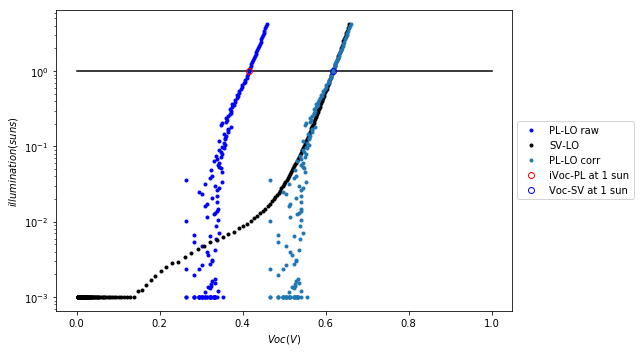

In [14]:
"""Sanity check for matching Suns-Voc and PL data"""
a = 21

fig, ax  = plt.subplots(figsize=(9,5), tight_layout=True)
ax.plot([0,1],[1,1],'k-')
ax.plot(PLDataListLO[a].iVoc, PLDataListLO[a].effSuns,'b.', label = 'PL-LO raw')
# ax.plot(PLDataListHI[a].iVoc, PLDataListHI[a].effSuns,'r.', label = 'PL-HI raw')
ax.plot(SunsDataListLO[a].raw['volt'], SunsDataListLO[a].effSuns,'k.', label = 'SV-LO')
# ax.plot(SunsDataListHI[a].raw['volt'], SunsDataListHI[a].effSuns,'k.', label = 'SV-HI')
ax.plot(PLDataListLO[a].iVoc_corr, PLDataListLO[a].effSuns,'.', label = 'PL-LO corr')
# ax.plot(PLDataListHI[a].iVoc_corr, PLDataListHI[a].effSuns,'.', label = 'PL-HI corr')

ax.plot(PLDataListLO[a].iVoc_1sun, 1, 'ro', fillstyle="none", label = 'iVoc-PL at 1 sun')
ax.plot(SunsDataListLO[a].Voc, 1, 'bo', fillstyle="none", label = 'Voc-SV at 1 sun')

# define the legend and set it to visible
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_visible(True)

# set the plot to log-log and set the limits and axis labels
plt.yscale("log")
# plt.xlim(0.2,0.9)
# plt.ylim(0.001,1e2)
plt.xlabel(r'$Voc (V)$')
plt.ylabel(r'$illumination (suns)$')
plt.show()

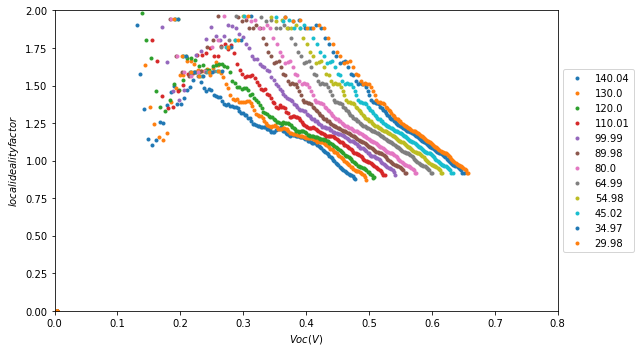

In [12]:
"""Sanity check for the matching of LO and HI data."""
a = 0
# ptHI = SunsDataListHI[a].indClosestVoc

fig, ax  = plt.subplots(figsize=(9,5), tight_layout=True)
# ax.plot(SunsDataListLO[a].raw['volt'][0], SunsDataListHI[a].highSunsHI, 'b+', label = 'HI point', markersize=15)
# ax.plot(SunsDataListLO[a].raw['volt'][0], SunsDataListLO[a].effSuns[0], 'ro', fillstyle="none", label = 'LO point', markersize=15)
# ax.plot(SunsDataListHI[a].raw['volt'], SunsDataListHI[a].effSuns,'.', label = 'HI[0]')
# ax.plot(SunsDataListLO[a].raw['volt'], SunsDataListLO[a].effSuns,'.', label = 'LO[0]')

ax.plot(SunsDataListLO[0].raw['volt'], SunsDataListLO[0].localIdeality,'.', label = str(SunsDataListLO[0].T))
ax.plot(SunsDataListLO[2].raw['volt'], SunsDataListLO[1].localIdeality,'.', label = str(SunsDataListLO[2].T))
ax.plot(SunsDataListLO[4].raw['volt'], SunsDataListLO[2].localIdeality,'.', label = str(SunsDataListLO[4].T))
ax.plot(SunsDataListLO[6].raw['volt'], SunsDataListLO[3].localIdeality,'.', label = str(SunsDataListLO[6].T))
ax.plot(SunsDataListLO[8].raw['volt'], SunsDataListLO[4].localIdeality,'.', label = str(SunsDataListLO[8].T))
ax.plot(SunsDataListLO[10].raw['volt'], SunsDataListLO[5].localIdeality,'.', label = str(SunsDataListLO[10].T))
ax.plot(SunsDataListLO[12].raw['volt'], SunsDataListLO[5].localIdeality,'.', label = str(SunsDataListLO[12].T))
ax.plot(SunsDataListLO[14].raw['volt'], SunsDataListLO[5].localIdeality,'.', label = str(SunsDataListLO[14].T))
ax.plot(SunsDataListLO[16].raw['volt'], SunsDataListLO[5].localIdeality,'.', label = str(SunsDataListLO[16].T))
ax.plot(SunsDataListLO[18].raw['volt'], SunsDataListLO[5].localIdeality,'.', label = str(SunsDataListLO[18].T))
ax.plot(SunsDataListLO[20].raw['volt'], SunsDataListLO[5].localIdeality,'.', label = str(SunsDataListLO[20].T))
ax.plot(SunsDataListLO[21].raw['volt'], SunsDataListLO[5].localIdeality,'.', label = str(SunsDataListLO[21].T))

# define the legend and set it to visible
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_visible(True)

# set the plot to log-log and set the limits and axis labels
# plt.yscale("log")
plt.xlim(0,0.8)
plt.ylim(0,2)
plt.xlabel(r'$Voc (V)$')
plt.ylabel(r'$local ideality factor$')
plt.show()